# COGS 108 - Final Project (change this to your project's title)

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [  ] YES - make available
* [X] NO - keep private

# Overview

*Fill in your overview here*

# Names

- Daniela Molina
- Gabriel Beal
- Marc Isaia
- Haoxuan Cui

<a id='research_question'></a>
# Research Question

There are currently a substantial amount of teenagers and young adults (ages 14-28) who use the top social media applications in the United States. Taking that into consideration, does extensive usage (2+ hours/day?) of the aforementioned applications by these users generate an onset of symptoms that correspond to the clinical criteria of an Anxiety Disorder and/or Depressive Disorder?

<a id='background'></a>

## Background & Prior Work

*Fill in your background and prior work here* 

References (include links):
- 1)
- 2)

# Hypothesis


*Fill in your hypotheses here*

# Dataset(s)

CSV from the Google Form Survey we conducted:
- Dataset Name: Social Media and Mental Health
- Link to the dataset: "Social Media and Mental Health.csv" in our Github Repo
- Number of Observations: 182
This dataset is the CSV file created from the responses received on our survey which collected data on social media use and mental health. It contains information about the individual’s identity, their social media usage (average time spent, which apps they use, when they first started using them), and their current mental health as well as whether they feel that it can be attributed to social media.

# Setup

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Statmodels & patsy
import patsy
import statsmodels.api as sm
from scipy.stats import pearsonr, norm, ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [3]:
df = pd.read_csv("Social_Media_and_Mental_Health.csv")

# Data Cleaning

The following are the steps we took to clean up our data.

In [4]:
# Rename columns
df.columns = ['time', 'gender', 'age', 'use social media', 'hours per day', 'days per week', 'check morning', 'check night', 'app count', 'start using', 'impact', 'mental health issues', 'suicidal thoughts', 'SM contributed', 'feedback']

# Remove responses with age over 28
df = df[df['age'] <= 28]

# Change yes and no to true and false
df = df.replace({"Yes": True, "No": False})

# Drop time column - not relevant to the research
df.drop(columns=['time'], inplace = True)

# Clean up time used
df["hours per day"] = df["hours per day"].str.replace(" hours", "")
df = df.replace({"Once a week": "1", "2-3 times a week": "2-3", "3-5 times a week": "3-5", "I use it every day":"7"})

# Clean up suicidal thoughts
df = df.replace({"a few times but have never acted on it": True, "Maybe ": "Prefer not to say", "Thought about it but can’t do it": True, "Passive suicidal thoughts. This means I do not really plan to ever commite sucide but instead just think about it as a option. Then, I snapped out of it because my mood imrpoves.": True})
df['suicidal thoughts'].value_counts()

# Change strings to numbers
df['age'] = pd.to_numeric(df['age'])
df['impact'] = pd.to_numeric(df['impact'])

# Save feedback in separate dataframe
df_feedback = df
df = df.drop(columns=['feedback'])

In [5]:
def cleanGender(string):
    if 'Female' in string:
        return 'Female'
    elif 'Male' in string:
        return 'Male'
    else:
        return 'Other'
df['gender'] = df['gender'].apply(cleanGender)

In [6]:
# Function to check whether the individual has Depression
def checkDepression(string):
    if 'Depression' in string:
        return True
    else:
        return False

In [7]:
# Function to check whether the individual has Anxiety
def checkAnxiety(string):
    if 'Anxiety' in string:
        return True
    else:
        return False

In [8]:
# Create new columns for whether the individual has Depression/Anxiety
df['Depression'] = df['mental health issues'].apply(checkDepression)
df['Anxiety'] = df['mental health issues'].apply(checkAnxiety)

# Removing mental health issues due to the reduced scope of the question
df = df.drop(columns=['mental health issues'])

In [9]:
# Function to count how many social media apps they use (out of the options we gave)
def appCount(string):
    if 'None of the above' in string:
        return 0
    semicolons = string.count(';')
    return semicolons + 1

In [10]:
# Get app count per individual
df['app count'] = df['app count'].apply(appCount)

In [11]:
# Change hours per day to quantitative variable by taking average of range
def hoursToInt(string):
    if string in "0-1":
        return 0.5
    elif string == "1-2":
        return 1.5
    elif string == "2-3":
        return 2.5
    elif string == "3-4":
        return 3.5
    else:
        return 4.5

In [12]:
df['average hours'] = df['hours per day'].apply(hoursToInt)

In [13]:
df

,gender,age,use social media,hours per day,days per week,check morning,check night,app count,start using,impact,suicidal thoughts,SM contributed,Depression,Anxiety,average hours
0,Female,22,True,2-3,3-5,True,False,2,Middle School,6,True,Maybe,True,True,2.5
1,Female,22,True,1-2,7,False,True,4,High School,7,False,Maybe,True,True,1.5
2,Female,21,True,4+,7,True,True,4,Elementary School,5,False,True,True,False,4.5
3,Female,19,True,4+,3-5,True,True,4,Elementary School,3,True,True,True,True,4.5
4,Female,21,True,2-3,7,True,True,2,High School,4,False,True,False,False,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,Male,24,True,3-4,7,True,True,1,Middle School,4,True,Maybe,True,True,3.5
178,Male,20,True,2-3,7,True,True,4,High School,5,False,False,False,False,2.5
179,Male,23,True,1-2,7,True,False,0,High School,3,False,True,False,False,1.5
180,Male,19,True,1-2,NaN,False,True,1,High School,5,True,False,False,False,1.5


In [14]:
df['gender'].value_counts()

Male      97
Female    73
Other     10
Name: gender, dtype: int64

# Data Analysis & Results

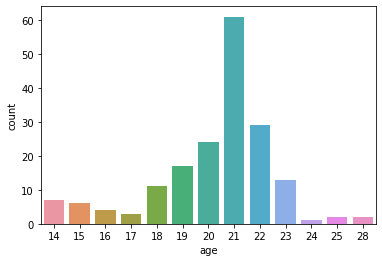

In [15]:
sns.countplot(x='age', data=df)

The graph above is a count of ages of respondents of our survey. We tried to target mainly young adults, since our research focuses on individuals who grew up or are growing up with social media applications.

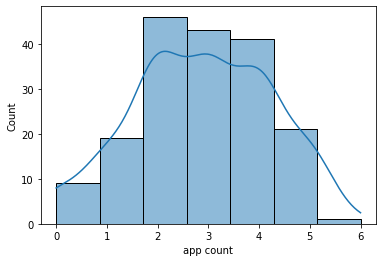

In [16]:
sns.histplot(df['app count'], bins=7, kde=True);

The histogram above illustrates that the majority of our respondents use between 2 to 4 of the top social media applications we listed (Facebook, Instagram, Snapchat, Twitter, TikTok and Reddit) regularly.

In [17]:
df.corr()

,age,use social media,app count,impact,Depression,Anxiety,average hours
age,1.000000,0.102915,0.181497,-0.159554,0.159373,0.017655,-0.076622
use social media,0.102915,1.000000,0.157101,-0.073916,0.060324,-0.086446,0.139682
app count,0.181497,0.157101,1.000000,-0.003878,0.199259,0.137714,0.214826
impact,-0.159554,-0.073916,-0.003878,1.000000,-0.078471,-0.115061,0.043047
Depression,0.159373,0.060324,0.199259,-0.078471,1.000000,0.427984,0.163435
Anxiety,0.017655,-0.086446,0.137714,-0.115061,0.427984,1.000000,0.206367
average hours,-0.076622,0.139682,0.214826,0.043047,0.163435,0.206367,1.000000


The table above shows the Pearson corrleation values between each variable in our dataframe.

The r value of app count and Depression is 0.199259, which means that there is a slight positive correlation between these two. The higher the app count, the more likely an individual is to have Depression. Similarly, the r value for app count and Anxiety is 0.137714. Although this value is slightly lower, there is still a small positive correlation between these two. The highter the app count, the more likely an individual is to have Anxiety.

The r value of average hours and Depression is 0.163435, which again tells us that there is a positive correlation. Average hours and Anxiety follows the same correlation but is slightly higher at 0.206367. From these values, we can conclude that the more hours an individual uses social media on a daily basis, the more likely they are to have Depression and Anxiety.

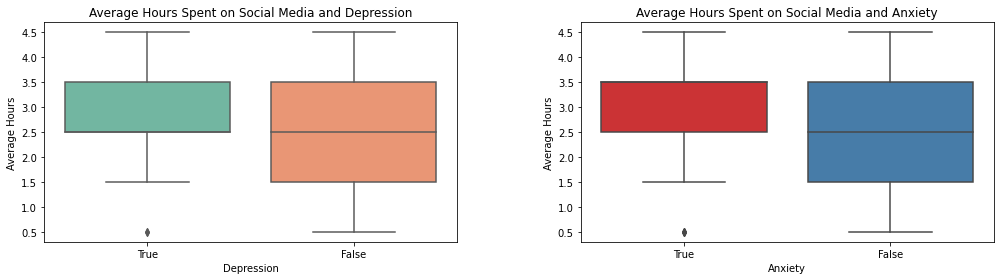

In [19]:
fig, ax = plt.subplots(1,2,figsize=(14,4))

ax1 = sns.boxplot(x='Depression', y='average hours', ax=ax[0], order=[True, False], data=df, palette='Set2')
ax1.set_ylabel("Average Hours")
ax1.set_title("Average Hours Spent on Social Media and Depression")

ax2 = sns.boxplot(x='Anxiety', y='average hours', ax=ax[1], order=[True, False], data=df, palette='Set1')
ax2.set_ylabel("Average Hours")
ax2.set_title("Average Hours Spent on Social Media and Anxiety")

fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

The boxplot above compares the distribution of the average hours an individual spends on social media between those who have Depression/Anxiety and those who do not. It shows us that the first quartile and the minimum of the set of respondents who have Depression/Anxiety is higher than that of those who don't, which can potentially indicate that the more average hours one spends on social media, the more likely they are to have Depression and or Anxiety.

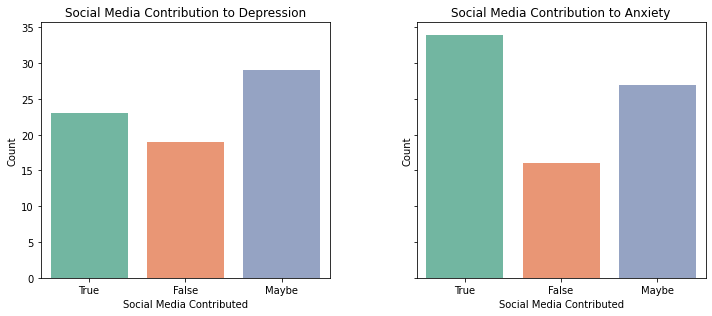

In [20]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(10,4.5))
ax1 = sns.countplot(x='SM contributed', data=df[df['Depression'] == True], ax=ax[0], order=[True, False, 'Maybe'], palette='Set2')
ax1.set_title('Social Media Contribution to Depression')
ax1.set_ylabel('Count')
ax1.set_xlabel('Social Media Contributed')
ax2 = sns.countplot(x='SM contributed', data=df[df['Anxiety'] == True], ax=ax[1], order=[True, False, 'Maybe'], palette='Set2')
ax2.set_title('Social Media Contribution to Anxiety')
ax2.set_ylabel('Count')
ax2.set_xlabel('Social Media Contributed')

fig.tight_layout()
plt.subplots_adjust(wspace=0.3)

The plots above demonstrate the count of people who have Depression/Anxiety and claimed that social media did, did not, or maybe did contribute to those mental health issues. Although many of the responses were Maybes, more people answered that they did feel social media contributed to their mental health issues, especially those with Anxiety.

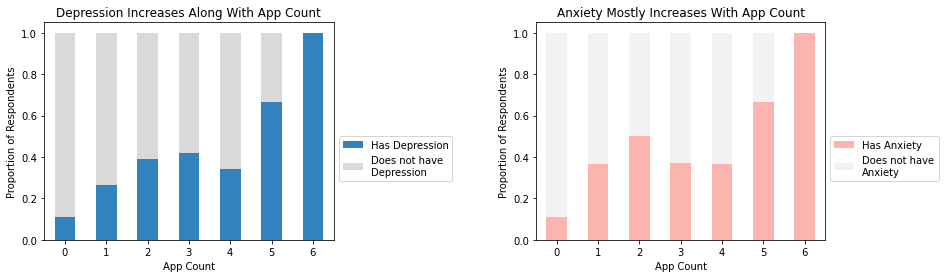

In [21]:
# 'Accent',
# 'Paired', 'Pastel2'
# 'Set2','YlGnBu_r',
# 'crest_r', 'gist_ncar','icefire','mako'
fig, ax = plt.subplots(1,2,figsize=(14,4))

df2 = df.groupby(['Depression','app count'])['Depression'].count().unstack('app count').fillna(0)
sub_df2 = np.transpose(df2.div(df2.sum()))
columns_titles = [True,False]
sub_df2 = sub_df2.reindex(columns=columns_titles)

# generate plot
ax1 = sub_df2.plot(kind='bar', stacked=True, rot=0, animated=True, colormap='tab20c',
                  title='Depression Increases Along With App Count', ax=ax[0])

# customize plot
ax1.legend(('Has Depression','Does not have\nDepression'), loc='best', bbox_to_anchor=(1.0, 0.5))
ax1.set_ylabel("Proportion of Respondents");
ax1.set_xlabel("App Count")

df2 = df.groupby([ 'Anxiety','app count'])['Anxiety'].count().unstack('app count').fillna(0)
sub_df2 = np.transpose(df2.div(df2.sum()))
columns_titles = [True,False]
sub_df2 = sub_df2.reindex(columns=columns_titles)

# generate plot
ax2 = sub_df2.plot(kind='bar', stacked=True, rot=0, colormap='Pastel1',
                  title='Anxiety Mostly Increases With App Count', ax=ax[1])

# customize plot
ax2.legend(('Has Anxiety','Does not have\nAnxiety'), loc='best', bbox_to_anchor=(1.0, 0.5))
ax2.set_ylabel("Proportion of Respondents");
ax2.set_xlabel("App Count")

plt.subplots_adjust(wspace=0.7)

The stacked barplots above illustrate the positive correlation that App Count has with Depression and Anxiety, respectively. They show that the groups of individuals who use more social media applications regularly have more cases of Depression and Anxiety. Although there are slight dips, there is an overall increasing trend.

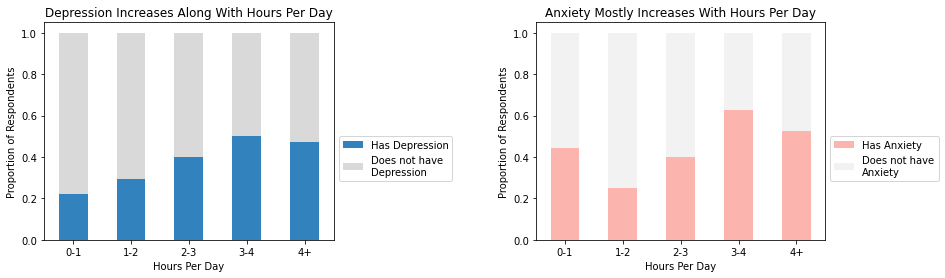

In [22]:
fig, ax = plt.subplots(1,2,figsize=(14,4))

df2 = df.groupby(['Depression','hours per day'])['Depression'].count().unstack('hours per day').fillna(0)
sub_df2 = np.transpose(df2.div(df2.sum()))
columns_titles = [True,False]
sub_df2 = sub_df2.reindex(columns=columns_titles)

# generate plot
ax1 = sub_df2.plot(kind='bar', stacked=True, rot=0, animated=True, colormap='tab20c',
                  title='Depression Increases Along With Hours Per Day', ax=ax[0])

# customize plot
ax1.legend(('Has Depression','Does not have\nDepression'), loc='best', bbox_to_anchor=(1.0, 0.5))
ax1.set_ylabel("Proportion of Respondents");
ax1.set_xlabel("Hours Per Day")

df2 = df.groupby([ 'Anxiety','hours per day'])['Anxiety'].count().unstack('hours per day').fillna(0)
sub_df2 = np.transpose(df2.div(df2.sum()))
columns_titles = [True,False]
sub_df2 = sub_df2.reindex(columns=columns_titles)

# generate plot
ax2 = sub_df2.plot(kind='bar', stacked=True, rot=0, colormap='Pastel1',
                  title='Anxiety Mostly Increases With Hours Per Day', ax=ax[1])

# customize plot
ax2.legend(('Has Anxiety','Does not have\nAnxiety'), loc='best', bbox_to_anchor=(1.0, 0.5))
ax2.set_ylabel("Proportion of Respondents");
ax2.set_xlabel("Hours Per Day")

plt.subplots_adjust(wspace=0.7)

The visuals above demonstrate the correlation between the hours an individual uses social media per day and the proportion of those respondents who have Depression or Anxiety, respectively. The left plot shows a positive trend bwteen Depression and Hours Per Day, indicating that those groups that use social media for more hours daily experience more Depression than those who do not. The graph on the right has a few peaks along the way, but demonstrates a similar idea since those with more daily hours have more Anxiety than those with less, with the exception of the 0-1 group. In both graphs we can see a peak in the 3-4 hours, which indicates that those individuals who use social media for that amount of time daily tend to have higher levels of Depression and Anxiety.

The following cells will perform Logistic Regression on the app count/average hours variables with Depression/Anxiety outcomes.

In [23]:
df.head()

,gender,age,use social media,hours per day,days per week,check morning,check night,app count,start using,impact,suicidal thoughts,SM contributed,Depression,Anxiety,average hours
0,Female,22,True,2-3,3-5,True,False,2,Middle School,6,True,Maybe,True,True,2.5
1,Female,22,True,1-2,7,False,True,4,High School,7,False,Maybe,True,True,1.5
2,Female,21,True,4+,7,True,True,4,Elementary School,5,False,True,True,False,4.5
3,Female,19,True,4+,3-5,True,True,4,Elementary School,3,True,True,True,True,4.5
4,Female,21,True,2-3,7,True,True,2,High School,4,False,True,False,False,2.5


In [24]:
# Shuffle dataset
df = df.sample(n=df.shape[0])
df.reset_index(drop=True, inplace=True)

# Only keep columns that we want to analyze in our model and convert categorical features (Not using 'start using'
# because it results in a lower accuracy score for our models)
gender = pd.get_dummies(df['gender'])

df_apps_depression = df[['age', 'app count', 'Depression']]
df_apps_depression = pd.concat([df_apps_depression,gender],axis=1)

df_apps_anxiety = df[['age', 'app count', 'Anxiety']]
df_apps_anxiety = pd.concat([df_apps_anxiety,gender],axis=1)

df_hours_depression = df[['age', 'average hours', 'Depression']]
df_hours_depression = pd.concat([df_hours_depression,gender],axis=1)

df_hours_anxiety = df[['age', 'average hours', 'Anxiety']]
df_hours_anxiety = pd.concat([df_hours_anxiety,gender],axis=1)

In [25]:
# Split datasets into training/testing
num_training = int(df.shape[0] * 0.8)
num_testing = int(df.shape[0] * 0.2)

train_X_apps_depression = df_apps_depression[:num_training].drop('Depression', axis=1)
test_X_apps_depression = df_apps_depression[-num_testing:].drop('Depression', axis=1)
train_y_apps_depression = df_apps_depression[:num_training]['Depression']
test_y_apps_depression = df_apps_depression[-num_testing:]['Depression']

train_X_apps_anxiety = df_apps_anxiety[:num_training].drop('Anxiety', axis=1)
test_X_apps_anxiety = df_apps_anxiety[-num_testing:].drop('Anxiety', axis=1)
train_y_apps_anxiety = df_apps_anxiety[:num_training]['Anxiety']
test_y_apps_anxiety = df_apps_anxiety[-num_testing:]['Anxiety']

train_X_hours_depression = df_hours_depression[:num_training].drop('Depression', axis=1)
test_X_hours_depression = df_hours_depression[-num_testing:].drop('Depression', axis=1)
train_y_hours_depression = df_hours_depression[:num_training]['Depression']
test_y_hours_depression = df_hours_depression[-num_testing:]['Depression']

train_X_hours_anxiety = df_hours_anxiety[:num_training].drop('Anxiety', axis=1)
test_X_hours_anxiety = df_hours_anxiety[-num_testing:].drop('Anxiety', axis=1)
train_y_hours_anxiety = df_hours_anxiety[:num_training]['Anxiety']
test_y_hours_anxiety = df_hours_anxiety[-num_testing:]['Anxiety']

In [26]:
# Fit training data on logistic regression models
clf_apps_depression = LogisticRegression(max_iter=1000, fit_intercept=False).fit(train_X_apps_depression, train_y_apps_depression)
clf_apps_anxiety = LogisticRegression(max_iter=1000, fit_intercept=False).fit(train_X_apps_anxiety, train_y_apps_anxiety)
clf_hours_depression = LogisticRegression(max_iter=1000, fit_intercept=False).fit(train_X_hours_depression, train_y_hours_depression)
clf_hours_anxiety = LogisticRegression(max_iter=1000, fit_intercept=False).fit(train_X_hours_anxiety, train_y_hours_anxiety)

Here, we are training four models with data to get the overall influence of the features on the outcome. The features in this case being an individual's identity (age and gender), as well as either App Count or Average Hours, and the outcome being Depression or Anxiety, depending on the model.

In [27]:
pred_apps_depression = clf_apps_depression.predict(test_X_apps_depression)
print(classification_report(test_y_apps_depression,pred_apps_depression))

              precision    recall  f1-score   support

       False       0.79      0.96      0.87        24
        True       0.86      0.50      0.63        12

    accuracy                           0.81        36
   macro avg       0.83      0.73      0.75        36
weighted avg       0.81      0.81      0.79        36



In [28]:
pred_hours_depression = clf_hours_depression.predict(test_X_hours_depression)
print(classification_report(test_y_hours_depression,pred_hours_depression))

              precision    recall  f1-score   support

       False       0.80      0.83      0.82        24
        True       0.64      0.58      0.61        12

    accuracy                           0.75        36
   macro avg       0.72      0.71      0.71        36
weighted avg       0.75      0.75      0.75        36



In [29]:
pred_apps_anxiety = clf_apps_anxiety.predict(test_X_apps_anxiety)
print(classification_report(test_y_apps_depression,pred_apps_anxiety))

              precision    recall  f1-score   support

       False       0.82      0.75      0.78        24
        True       0.57      0.67      0.62        12

    accuracy                           0.72        36
   macro avg       0.69      0.71      0.70        36
weighted avg       0.74      0.72      0.73        36



In [30]:
pred_hours_anxiety = clf_hours_anxiety.predict(test_X_hours_anxiety)
print(classification_report(test_y_hours_depression,pred_hours_anxiety))

              precision    recall  f1-score   support

       False       0.79      0.79      0.79        24
        True       0.58      0.58      0.58        12

    accuracy                           0.72        36
   macro avg       0.69      0.69      0.69        36
weighted avg       0.72      0.72      0.72        36



The values above indicate that our Logistic Regression models were trained well enough to receive an average accuracy of about 0.70, which is pretty good considering the size of our training set.

In [31]:
# Feature importance (with app count) on Depression
weights_app_depression = list(zip(clf_apps_depression.coef_.tolist()[0], ['age', 'app count'] + list(gender)))
weights_app_depression.sort()
weights_app_depression_df = pd.DataFrame(weights_app_depression, columns=['Weight', 'Feature'])
weights_app_depression_df.style.set_caption("Feature Weights with App Count on Depression")

,Weight,Feature
0,-1.03951,Male
1,-0.277492,Female
2,-0.00956583,age
3,0.15286,app count
4,0.596274,Other


The DataFrame above describes all of the feature weights, including the individual's identity and their app count on the outcome of whether they have Depression or not. App Count has a positive weight, which indicates that as app count increases, the individual is more likely to have Depression.

In [32]:
# Feature importance (with average hours) on Depression
weights_hours_depression = list(zip(clf_hours_depression.coef_.tolist()[0], ['age', 'average hours'] + list(gender)))
weights_hours_depression.sort()
weights_hours_depression_df = pd.DataFrame(weights_hours_depression, columns=['Weight', 'Feature'])
weights_hours_depression_df.style.set_caption("Feature Weights with Average Hours on Depression")

,Weight,Feature
0,-1.05635,Male
1,-0.246869,Female
2,0.0101787,age
3,0.0171015,average hours
4,0.622172,Other


The DataFrame above describes all of the feature weights, including the individual's identity and their average hours spent daily on social media on the outcome of whether they have Depression or not. Average Hours has a positive weight, which indicates that as the average hours increase, the individual is more likely to have Depression, but is not as strong as the weight of App Count on Depression.

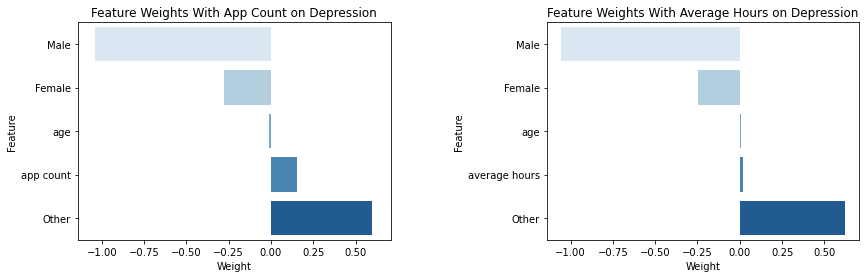

In [33]:
fig, ax = plt.subplots(1,2,figsize=(14,4), sharex=True)

# Plot feature weights
ax1 = sns.barplot(x='Weight', y='Feature', data=weights_app_depression_df, palette='Blues', ax=ax[0])
ax1.set_title("Feature Weights With App Count on Depression")

# Plot feature weights
ax2 = sns.barplot(x='Weight', y='Feature', data=weights_hours_depression_df, palette='Blues', ax=ax[1])
ax2.set_title("Feature Weights With Average Hours on Depression")

plt.subplots_adjust(wspace=0.5)

The plots above are visualizations of the previous two DataFrames. They both demonstrate that Males are less likely to have Depression than Females and any other gender appears to experience Depression at much higher rates. The important thing to take out of these plots is that App Count and Average Hours have a positive weight, which means that they have a positive correlation with Depression, and App Count has a slightly higher weight than Average Hours, thus App Count is a greater influence towards Depression.

In [34]:
# Feature importance (with app count) on Anxiety
weights_app_anxiety = list(zip(clf_apps_anxiety.coef_.tolist()[0], ['age', 'app count'] + list(gender)))
weights_app_anxiety.sort()
weights_app_anxiety_df = pd.DataFrame(weights_app_anxiety, columns=['Weight', 'Feature'])
weights_app_anxiety_df.style.set_caption("Feature Weights with App Count on Anxiety")

,Weight,Feature
0,-0.984826,Male
1,-0.00905927,age
2,0.105203,app count
3,0.109129,Female
4,1.05433,Other


The DataFrame above describes all of the feature weights, including the individual's identity and their amount of social media applications, on the outcome of whether they have Anxiety or not. App Count has a positive weight, which indicates that as one's social media app count increases, they are more likely to have Anxiety.

In [35]:
# Feature importance (with average hours) on Depression
weights_hours_anxiety = list(zip(clf_hours_anxiety.coef_.tolist()[0], ['age', 'average hours'] + list(gender)))
weights_hours_anxiety.sort()
weights_hours_anxiety_df = pd.DataFrame(weights_hours_anxiety, columns=['Weight', 'Feature'])
weights_hours_depression_df.style.set_caption("Feature Weights with Average Hours on Anxiety")

,Weight,Feature
0,-1.05635,Male
1,-0.246869,Female
2,0.0101787,age
3,0.0171015,average hours
4,0.622172,Other


The DataFrame above describes all of the feature weights, including the individual's identity and the average amount of hours they spend on social media applications daily, on the outcome of whether they have Anxiety or not. Average Hours has a positive weight, which indicates that as one's social media app count increases, they are more likely to have Anxiety, but it is lower than the weight of App Count, which means a high Average Hours value is a stronger indicator that the individual has Anxiety than their App Count.

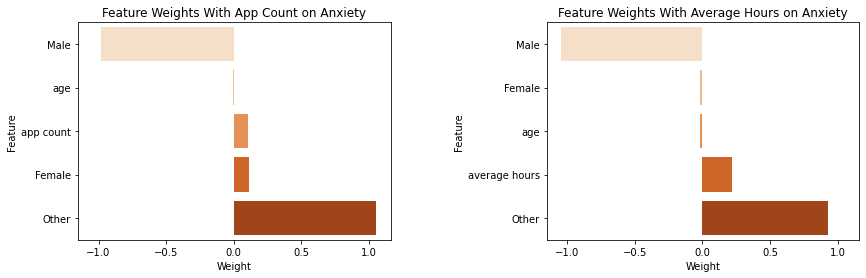

In [36]:
fig, ax = plt.subplots(1,2,figsize=(14,4), sharex=True)

# Plot feature weights
ax1 = sns.barplot(x='Weight', y='Feature', data=weights_app_anxiety_df, palette='Oranges', ax=ax[0])
ax1.set_title("Feature Weights With App Count on Anxiety")

# Plot feature weights
ax2 = sns.barplot(x='Weight', y='Feature', data=weights_hours_anxiety_df, palette='Oranges', ax=ax[1])
ax2.set_title("Feature Weights With Average Hours on Anxiety")

plt.subplots_adjust(wspace=0.5)

The plots above are visualizations of the previous two DataFrames. They both demonstrate that Males are less likely to have Anxiety than Females and any other gender appears to experience Anxiety at much higher rates. Being Female also has a positive weight on Anxiety. The important thing to take out of these plots is that App Count and Average Hours have a positive weight, similar to the Depression plots, which means that they have a positive correlation with Anxiety, and Average Hours has a slightly higher weight than App Count, thus Average Hours is a greater influence towards Anxiety.

In [ ]:
# Get all weights we want to compare
feat_weights = pd.DataFrame()
feat_weights = feat_weights.append(weights_hours_anxiety_df[weights_hours_anxiety_df['Feature'] == 'average hours'], ignore_index=True)
feat_weights.loc[0, 'Feature'] = 'Hours Impact \n on Anxiety'
feat_weights = feat_weights.append(weights_app_anxiety_df[weights_app_anxiety_df['Feature'] == 'app count'], ignore_index=True)
feat_weights.loc[1, 'Feature'] = 'App Count \n Impact on \n Anxiety'
feat_weights = feat_weights.append(weights_hours_depression_df[weights_hours_depression_df['Feature'] == 'average hours'], ignore_index=True)
feat_weights.loc[2, 'Feature'] = 'Hours Impact \n on Depression'
feat_weights = feat_weights.append(weights_app_anxiety_df[weights_app_anxiety_df['Feature'] == 'app count'], ignore_index=True)
feat_weights.loc[3, 'Feature'] = 'App Count \n Impact on \n Depression'
feat_weights.sort_values(by='Weight', inplace=True, ascending=False)

In [ ]:
# Plot the weights
ax = sns.barplot(y='Weight', x='Feature', data=feat_weights, palette='Purples_r')
ax.set_title('Feature Weights')

The bar plot above illustrates the weights of Average Hours and App Count on Depression and Anxiety. From this, we can see that the Average Hours feature on Anxiety has the highest weight, which indicates that the amount of time an individual spends on social media daily has the greatest impact on whether they have Anxiety. This is followed by the impact that the amount of social media apps has on whether an individual has Anxiety and Depression. Lastly, the smallest weight is that of Average Hours on Depression. However, it is important to note that all of these weights are positive, meaning that as one's app count and average hours spent on social media increases, so does their likelihood of being Depressed and/or having Anxiety.

# Ethics & Privacy

*Fill in your ethics & privacy discussion here*

# Conclusion & Discussion

*Fill in your discussion information here*

# Team Contributions

*Specify who in your group worked on which parts of the project.*